<a href="https://colab.research.google.com/github/Alex86Mart/MAG_86/blob/main/Project_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PROJECT_4

ЦЕЛЬ

Подготовить основу рекомендательной системы.

ФОРМАЛИЗОВАННЫЕ ЗАДАЧИ

1. Познакомиться с датасетом, подготовить и проанализировать данные с помощью SQL.
2. Обработать данные средствами Python.
3. Составить итоговую таблицу с рекомендациями, снабдив её необходимыми комментариями, и представить отчёт продакт-менеджеру.
4. Проанализировать результаты A/B-теста, проведённого после внедрения фичи, и сделать вывод.

SQL ЗАПРОС

WITH users_WITH_courses AS
     (SELECT
         DISTINCT user_id,
         COUNT(DISTINCT resource_id) cnt_courses
     FROM  final.carts c  
         JOIN final.cart_items ci ON c.id = ci.cart_id
         WHERE  resource_type = 'Course' AND state = 'successful'
     GROUP BY 1
     HAVING COUNT (DISTINCT resource_id) > 1)
     SELECT  
         DISTINCT users_WITH_courses.user_id,
         resource_id
     FROM  final.carts c
         JOIN final.cart_items ci ON ci.cart_id = c.id
         INNER JOIN users_WITH_courses ON c.user_id = users_WITH_courses.user_id
         WHERE  resource_type = 'Course' AND state = 'successful'
     ORDER BY 1,2



In [ ]:
# Импорт библиотек
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from itertools import combinations
from collections import Counter

In [ ]:
# Загрузка и преобразование в датафрейм итогового запроса в SQL
df = pd.read_csv('data/query_result_2024-05-20.csv', sep = ',')
# Получение информацию о файле
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34074 entries, 0 to 34073
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   user_id      34074 non-null  int64
 1   resource_id  34074 non-null  int64
dtypes: int64(2)
memory usage: 532.5 KB


In [ ]:
# Выведем десять первых строк, чтобы познакомиться с данными
df.head(10)

,user_id,resource_id
0,51,516
1,51,1099
2,6117,356
3,6117,357
4,6117,1125
5,10275,553
6,10275,1147
7,10457,361
8,10457,1138
9,17166,356


In [ ]:
# Определяем все варианты пар курсов в покупках клиентов
pair = df.groupby('user_id')['resource_id'].apply(lambda x: list(np.unique(x))).reset_index()
pairs = pd.DataFrame(pair['resource_id'].apply(lambda x: list(combinations(x, 2))))
pairs_list = pairs['resource_id'].to_list()
list_pair = []
for item in pairs_list:
    for i in item:
        list_pair.append(i)
set_pair = set(list_pair)
len(set_pair)
print(f"Всего в покупка клиентов: {len(set_pair)} вариантов пар")

Всего в покупка клиентов: 3989 вариантов пар


In [ ]:
# Определяем самую популярную пару курсов в покупках клиентов
count_pair = Counter(list_pair)
count_pair.most_common(1)

[((551, 566), 797)]

In [ ]:
# Преобразуем счётчик пар курсо в датафрейм для получения статистических данных
df_count_pair = pd.DataFrame.from_dict(count_pair, orient= 'index').reset_index()
df_count_pair = df_count_pair.rename(columns = {'index':'pair', 0: 'count'})
df_count_pair = df_count_pair.sort_values(by = 'count', ascending=False).reset_index(drop=True)
df_count_pair.describe().round()

,count
count,3989.0
mean,10.0
std,26.0
min,1.0
25%,1.0
50%,3.0
75%,9.0
max,797.0


МИНИМАЛЬНАЯ ГРАНИЦА ДЛЯ РЕКОМИДАЦИИ КУРСОВ

В качестве минимальной границы при определении популярности пар курсов возьмём данные выше третьего квартиля. Выборка останется достаточно большой, при этом из рекомендаций исключим редко встречающиеся пары курсов.

In [ ]:
# Датафрейм десяти популярных пар курсов
df_count_pair_popular = df_count_pair[df_count_pair['count']>9]
df_count_pair_popular.head(10)

,pair,count
0,"(551, 566)",797
1,"(515, 551)",417
2,"(489, 551)",311
3,"(523, 551)",304
4,"(566, 794)",290
5,"(489, 515)",286
6,"(490, 566)",253
7,"(490, 551)",247
8,"(570, 752)",247
9,"(569, 572)",216


Text(0.5, 1.0, 'Частота покупок для выборки среди пар курсов')

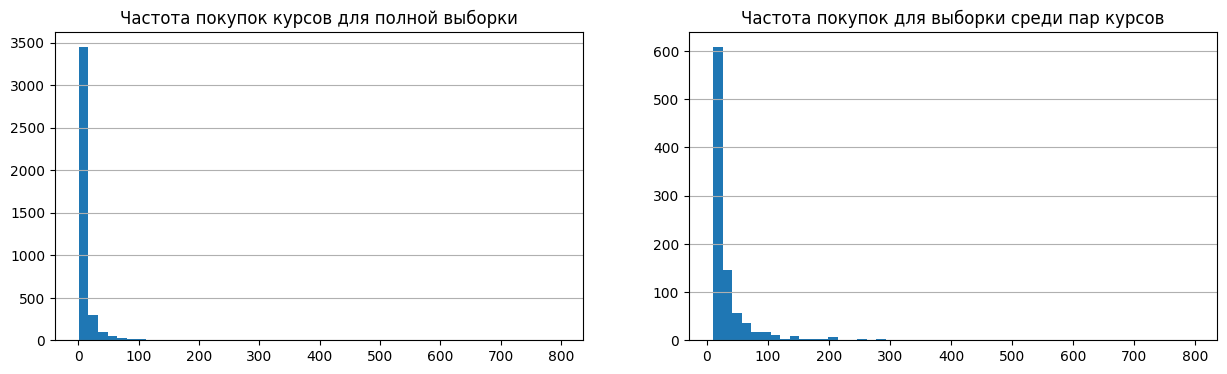

In [ ]:
# График частотности пар курсов в корзинахклиентов
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
axes[0].hist(x = df_count_pair['count'],bins=50)
axes[1].hist(x = df_count_pair_popular['count'],bins=50)

axes[0].grid(axis='y')
axes[1].grid(axis='y')
axes[0].set_title('Частота покупок курсов для полной выборки')
axes[1].set_title('Частота покупок для выборки среди пар курсов')

In [ ]:
# Уникальные курсы в корзинах клиентов
course_unique = df['resource_id'].sort_values().unique().tolist()
len(course_unique)

126

ПРИМЕЧАНИЕ

Количество уникальных курсов в нашей итоговой выборке 126, что отличается от обшего количества уникальных курсов(127), полученного на этапе сбора данных. Это связано с тем, что по ТЗ мы для рекомендаций используем только те курсы, которые были приобретены клиентами. На этапе сбора данных мы учитывали все курсы в корзине клиентов, в том числе и пока ещё не приобретённых. Для того, чтобы дать рекомендации всем курсам на платформе, выгрузим из SQL список ID 127 курсов.


ЗАПРОС SQL

SELECT DISTINCT resource_id
FROM final.cart_items
WHERE resource_type = 'Course'

In [ ]:
# Загрузка и преобразование в датафрейм запроса в SQL
courses = pd.read_csv('data/query_result_2024-05-26.csv', sep = ',')
# Получение информацию о файле
courses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   resource_id  127 non-null    int64
dtypes: int64(1)
memory usage: 1.1 KB


In [ ]:
# Создание листа с уникальными id курсов
courses_list = courses['resource_id'].sort_values().to_list()
len(courses_list)

127

In [ ]:
# Определим id курса, ранее не приобретавшегося клиентами
not_course = list(set(courses_list) - set(course_unique))
not_course

[772]

In [ ]:
# Создаём список из двух самых популярных курсов
popular = pd.DataFrame(df.groupby('resource_id')['user_id'].count()).reset_index()
popular = popular.sort_values(by='user_id',ascending=False).reset_index()
popular_list = popular['resource_id'][:2].to_list()
popular_list

[551, 566]

In [ ]:
# Создадим таблицу с рекоминдациями, куда добавим ранее неприобретаемый курс с рекомендациями самых популярных курсов
data = {'course':[not_course[0]], 'recom_1':[popular_list[0]],'recom_2':[popular_list[1]]}
df_recom = pd.DataFrame(data)
df_recom

,course,recom_1,recom_2
0,772,551,566


In [ ]:
# Функция рекоминдаций для курса по его id
def recom(course):
    rec_list = []
    for i in count_pair.keys():
        if i[0] == course:
            rec_list.append((i, count_pair[i]))
        if i[1] == course:
            rec_list.append((i, count_pair[i]))
    rec_list = sorted(rec_list, key=lambda x:x[1], reverse=True)
    return rec_list[:2]
recom(490)

[((490, 566), 253), ((490, 551), 247)]

In [ ]:
# Установим лимит
limit = np.percentile(df_count_pair['count'],75)
limit

9.0

In [ ]:
# Запоняем итоговую рекомендательную таблицу
for i in course_unique:
    course = i
    if recom(i)[0][1] > limit:
        if recom(i)[0][0][0] == course:
            recom_1 = recom(i)[0][0][1]
        else:
            recom_1 = recom(i)[0][0][0]
    elif recom(i)[1][1] > limit:
        if recom(i)[1][0][0] == course:
            recom_2 = recom(i)[1][0][1]
        else:
            recom_2 = recom(i)[1][0][0]
    else:
        recom_1 = popular_list[0]
        recom_2 = popular_list[1]
    df_2 = pd.DataFrame({'course':[course], 'recom_1':[recom_1], 'recom_2':[recom_2]})
    df_recom = pd.concat([df_recom, df_2], ignore_index=True)
df_recom

,course,recom_1,recom_2
0,772,551,566
1,356,571,566
2,357,571,566
3,358,570,566
4,359,570,566
...,...,...,...
122,1188,1141,566
123,1198,551,566
124,1199,551,566
125,1200,551,566


In [ ]:
# Курсы для рекомендации(самый популярный и второй по популярности)
recom = [((490, 566), 253), ((490, 551), 247)]
print(f"Самый популярный курс: {recom[0][0][1]}")
print(f"Второй по популярности курс: {recom[1][0][1]}")

Самый популярный курс: 566
Второй по популярности курс: 551


ВЫВОДЫ:

Самый популярный курс на платформе с ID 566, данный курс встречается в корзинах покупателей 253 раза. Второй по популярности курс является с ID 551, он стречается в корзинах покупателей 247 раз.